## Install packages and libraries

https://web2.qatar.cmu.edu/~gdicaro/15382-Spring18/hw/hw3-files/pso-book-extract.pdf

In [2]:
# Install the Pyomo package and the CBC solver to use within this notebook
use_pyomo = 0
if use_pyomo:
  _ = !sudo apt install -qq libglpk-dev python3.8-dev libgmp3-dev
  _ = !apt-get install -y -qq coinor-cbc
  _ = !pip install -q pyomo
  _ = !pip install -U pymoo
  import pyomo
  import pyomo.environ as pyo
  import pyomo.gdp as gdp
  from IPython.display import Markdown
  from pyomo.environ import SolverFactory
  from pymoo.algorithms.moo.nsga2 import NSGA2
  from pymoo.problems import get_problem
  from pymoo.optimize import minimize
  from pymoo.visualization.scatter import Scatter
  from pymoo.core.problem import Problem
  # Use CBC solver
  solver = SolverFactory('cbc', executable='/usr/bin/cbc')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import truncnorm
import requests
import types
import time
from sklearn.neighbors import BallTree
import random


## Mount drive before continuing

### Read in data

In [3]:
car_data = pd.read_csv('/content/drive/MyDrive/MOPTA/MOPTA2023_car_locations.csv')
car_data = np.array(car_data)

## Define structure of individuals and population

In [31]:
# Define individual structures

n_individual = 600 # stations in an individual
pop_size = 1000 # number of individuals
x_max = 290 # size of search space on x axis
y_max = 150 # size of search space on y axis
max_chargers = 8 # max number of chargers at a station

generations = 100

# cost parameters
driving_cost_per_mile = 0.041
charging_cost_per_mile = 0.0388
construction_cost_per_station = 5000
maintenance_fee_per_charger = 500
no_assignment_penalty = 5000
exceed_range_penalty = 5000

# define the population
options = {'c1': 0.09, 'c2': 0.15, 'w':0.97}

# uniform distribution for generating random points in the search space
ud_x = uniform(0, x_max)
ud_y = uniform(0, y_max)

# uniform distribution for generating random number between 0 and 1
ud = uniform(0,1)

# global best station positions
car_anchors = np.random.choice(list(range(car_data.shape[0])), n_individual)
car_data_anchor = car_data[car_anchors]
global_best_stations = car_data_anchor # np.array([[ud_x.rvs(1)[0],ud_y.rvs(1)[0]] for i in range(n_individual)]) # position of every station in the global best
# global best score
global_best_score = 1000000000
global_best_station_counter, global_best_index = None,None

local_best_scores = [1e9 for i in range(pop_size)] # storing local best scores (not positions)

class Ranges:

  def __init__(self, ranges):
    self.ranges = ranges

class Individual:

  def __init__(self, ident, positions, chargers, velocities):
    self.ident = ident
    self.positions = positions # numpy array of x,y positions of all stations
    self.chargers = chargers # numpy array of number of chargers per station
    self.velocities = velocities # numpy array of x,y velocity of each station
    self.best_positions = positions # numpy array of best configuration for the station
    self.cost = 0
    self.vehicle_assignments = None
    self.assignment_proportion = None
    self.station_counter = None
    self.distance_to_station = None
    self.total_cost_no_penalty = None

  def update_positions(self, global_best_stations, g:list): # global best stations must be a numpy array with x,y coords of the best global configuration
    c1 = (0.08 - 0.15) * g[0] / g[1] + 0.15
    c2 = (0.15 - 0.08) * g[0] / g[1] + 0.08
    inertia_components = options['w'] * (self.velocities)
    cognitive_components = ud.rvs(1) * c1 * (self.best_positions - self.positions)
    social_components = ud.rvs(1) * c2 * (global_best_stations - self.positions)

    new_velocities = inertia_components + cognitive_components + social_components
    new_positions = new_velocities + self.positions

    # Replace out-of-range x,y values with random values between 0 and x_max,y_max
    if new_positions[new_positions[:,0] > x_max].shape[0] > 0:
      new_positions[new_positions[:, 0] > x_max, 0] = np.random.uniform(0, x_max, size=np.sum(new_positions[:, 0] > x_max))
    if new_positions[new_positions[:,1] > y_max].shape[0] > 0:
      new_positions[new_positions[:, 1] > y_max, 1] = np.random.uniform(0, y_max, size=np.sum(new_positions[:, 1] > y_max))
    if new_positions[new_positions[:,0] < 0].shape[0] > 0:
      new_positions[new_positions[:, 0] < 0, 0] = np.random.uniform(0, x_max, size=np.sum(new_positions[:, 0] < 0))
    if new_positions[new_positions[:,1] < 0].shape[0] > 0:
      new_positions[new_positions[:, 1] < 0, 1] = np.random.uniform(0, y_max, size=np.sum(new_positions[:, 1] < 0))

    new_positions.reshape(n_individual, 2)

    self.positions = new_positions
    self.velocities = new_velocities

### Generate population

In [32]:
nd = norm(1,0.5) # normal distribution for sampling velocities

car_anchors = np.random.choice(list(range(car_data.shape[0])), n_individual)
car_data_anchor = car_data[car_anchors]
def gen_pop(pop_size, car_data_anchor):
  population = {} # empty dictionary to fill with individuals to make population
  for i in range(pop_size):
    # generating random x,y positions for the individual stations

    # uniform distribution for generating random points in the search space
    spawn_radius = 10
    ud_x = uniform(-spawn_radius, spawn_radius)
    ud_y = uniform(-spawn_radius, spawn_radius)

    noise = ud_x.rvs((n_individual,2))

    positions = np.zeros_like(noise)

    for s in range(car_anchors.shape[0]):
      positions[s] = noise[s] + car_data_anchor[s]

    # positions = np.dstack([ud_x.rvs(n_individual), ud_y.rvs(n_individual)]).reshape(n_individual,2)
    # abs_pos = positions[:,0] + positions[:,1]
    # temp = np.hstack([positions, abs_pos.reshape(positions.shape[0],1)])
    # temp = temp[temp[:,2].argsort()]
    # positions = temp[:,:2]
    velocities=nd.rvs(size=(n_individual, 2)) * np.random.choice([1,-1], size=(n_individual, 2)) # sampling velocities from random dist
    population.update({i : Individual(ident=i,
                                      positions=positions.copy(),
                                      chargers=np.random.choice(list(range(1,9))),
                                      velocities=velocities)}
                      )
  return population
  
population = gen_pop(pop_size, car_data_anchor)

### Sample vehicle ranges

In [33]:
# get sample of vehicle ranges
min_range = 20
max_range = 250
mean_range = 100
sd_range = 50

# sample ranges for each vehicle
def get_samples(min_range=min_range,
                max_range=max_range,
                mean_range=mean_range,
                sd_range=sd_range):
    pd = truncnorm((min_range - mean_range) / sd_range, 
                   (max_range - mean_range) / sd_range, 
                   loc=mean_range, scale=sd_range)
    samples = pd.rvs(size=(car_data.shape[0], 10))
    samples_aggregated = np.mean(samples, axis=1)

    return samples_aggregated

# ranges sampled
samples = get_samples()
rng = Ranges(ranges=samples)

## Evaluation function

In [36]:
def compute_visiting_probability(ranges:np.array, lam:float=0.012):
    return np.exp(-lam**2 * (ranges - 20)**2 )

# Calculate the pairwise distances between points in the two arrays
def calculate_distance(car_location, station_location):
    return np.linalg.norm(car_location - station_location, axis=1)

def KNN(population, K):
  S = 16
  for individual in range(pop_size):

    ########## IDEA: mutate dormant stations to accelarate towards full stations

    # K = 20 # number of nearest-stations to find for a vehicle

    ranges = get_samples() # rng.ranges#

    # get visiting probabilities
    c = compute_visiting_probability(ranges)
    # number of vehicles per batch
    v_b = np.round(c * 10, 0)
    # exclude vehicles with a low probability of charging
    exclusion = 0 # 0.2*10

    # vehicle batches which have a strong enough probability of visiting a charger
    applicable_vehicles = np.array([v for v in range(v_b.shape[0]) if v_b[v] > exclusion])
    applicable_ranges = ranges[applicable_vehicles]

    v_b = v_b[applicable_vehicles]

    vehicle_positions = car_data[applicable_vehicles]

    # station positions
    station_dict = {j : population[individual].positions[j] for j in range(n_individual)}
    # station position array
    station_positions = np.array([station_dict[i] for i in station_dict])

    # find the indices of applicable stations
    tree = BallTree(station_positions, leaf_size=2)
    # ind = tree.query_radius(vehicle_positions, r=applicable_ranges) # indices of stations that are in range of vehicles
    # ind_range = tree.query_radius(vehicle_positions, r=applicable_ranges) # indices of stations that are in range of vehicles
    dist, ind_closest = tree.query(vehicle_positions, k=K) # indices of closest stations

    # dictionary of how many chargers at each station
    station_counter = {i : 0 for i in range(station_positions.shape[0])}
    vehicle_assignments = {i : None for i in range(vehicle_positions.shape[0])}
    distance_to_station = []
    charging_costs = []
    driving_costs = []

    # shuffle_vehicle_indices = list(range(vehicle_positions.shape[0]))
    # random.shuffle(shuffle_vehicle_indices)

    # assign vehicles in order of demand, i.e. higher demand nodes get assigned first (means higher prob of charging)
    shuffle_vehicle_indices = np.argsort(v_b)[::-1]

    assigned = 0

    # for each vehicle, find a station with availability and add the vehicle batch to that station
    for v in shuffle_vehicle_indices:
      # first check if any of the nearby stations are already in use
      stations_in_use = [ind for ind in ind_closest[v] if (station_counter[ind] + v_b[v] <= S and station_counter[ind] > 0)]
      for ind in range(ind_closest[v].shape[0]):
        if (station_counter[ind_closest[v][ind]] + v_b[v] <= S and ind_closest[v][ind] in stations_in_use): 
          station_counter[ind_closest[v][ind]] += v_b[v]
          vehicle_assignments[v] = ind_closest[v][ind]
          distance_to_station.append(dist[v][ind])
          charging_costs.append(charging_cost_per_mile * v_b[v] * (250 - applicable_ranges[v] - dist[v][ind]))
          driving_costs.append(driving_cost_per_mile * v_b[v] * dist[v][ind])
          assigned += 1
          break
      for ind in range(ind_closest[v].shape[0]):
        if (station_counter[ind_closest[v][ind]] + v_b[v] <= S and ind_closest[v][ind] not in stations_in_use):
          station_counter[ind_closest[v][ind]] += v_b[v]
          vehicle_assignments[v] = ind_closest[v][ind]
          distance_to_station.append(dist[v][ind])
          charging_costs.append(charging_cost_per_mile * v_b[v] * (250 - applicable_ranges[v] - dist[v][ind]))
          driving_costs.append(driving_cost_per_mile * v_b[v] * dist[v][ind])
          assigned += 1
          break

    # calculate the cost
    # driving cost
    driving_cost = sum(driving_costs)
    # charging cost
    charging_cost = sum(charging_costs)
    # station cost, charger cost
    station_cost, charger_cost = 0,0
    for s in station_counter:
      station_cost += construction_cost_per_station * (station_counter[s] > 0)
      charger_cost += maintenance_fee_per_charger * station_counter[s]
    # penalty cost (% assigned) (1-pct_assigned)*M
    pct_assigned = assigned/vehicle_positions.shape[0]
    penalty_cost_no_assignment_made = (vehicle_positions.shape[0] - assigned) * no_assignment_penalty # no_assignment_penalty * (vehicle_positions.shape[0] - assigned) # (1-pct_assigned) * 
    # penalty cost for exceeding range
    ranges_resort = np.array([applicable_ranges[i] for i in shuffle_vehicle_indices])
    distance_to_station_ar = np.array(distance_to_station)
    # penalty_cost_exceeding_range = exceed_range_penalty * sum(distance_to_station_ar > ranges_resort)

    # distance penalty for unassigned stations must be more than the distance cost

    distance_cost = sum(np.array(distance_to_station)**2) * 10

    total_cost_no_penalty = driving_cost + charging_cost + station_cost + charger_cost
    total_cost = total_cost_no_penalty + penalty_cost_no_assignment_made + distance_cost # penalty_cost_exceeding_range

    population[individual].cost = total_cost
    population[individual].assignment_proportion = pct_assigned
    population[individual].station_counter = station_counter
    population[individual].vehicle_assignments = vehicle_assignments
    population[individual].distance_to_station = distance_to_station
    


    if total_cost < local_best_scores[individual]:
      local_best_scores[individual] = total_cost
      population[individual].best_positions = population[individual].positions
    population[individual].total_cost_no_penalty = total_cost_no_penalty


# print("{:.3f} seconds".format(time.time()-start))
# print("{:.3f}% assigned".format(100*pct_assigned))
# print("Mean distance to station: {:.2f}".format(np.mean(distance_to_station)))
# print("Total cost: {:.2f}".format(total_cost))
# plt.title('Histogram of distance to station')
# plt.xlabel('Distance')
# plt.hist(distance_to_station, alpha=0.5)
# plt.show()

In [37]:
def evaluate(population, vehicles, global_best_score, global_best_stations, local_best_scores, K, global_best_station_counter, global_best_index):
    '''
    The vehicle-->station assignments are be made in this function and the cost is evaluated
    '''

    # print('Solving assignment problem...')
    KNN(population, K)
    # print('Assignment solved for population')

    population_fitness = []
    population_fitness_no_penalty = []
    for i in range(pop_size):
      population_fitness.append(population[i].cost)
      population_fitness_no_penalty.append(population[i].total_cost_no_penalty)
    
    if min(population_fitness) <= global_best_score:
      global_best_score = min(population_fitness)
      global_best_stations = population[np.argmax(population_fitness)].positions
      global_best_station_counter = population[np.argmax(population_fitness)].station_counter
      global_best_index = np.argmax(population_fitness)
      # print('Updated global best')
    # print("Evaluation Complete\n----------------------------")
    
    return global_best_score, global_best_stations, global_best_station_counter, global_best_index, local_best_scores, population_fitness, population_fitness_no_penalty

In [38]:
# evaluate(population, car_data, global_best_score, global_best_stations, local_best_scores)

In [39]:
# ud_x = uniform(0, x_max)
# ud_y = uniform(0, y_max)
# car_data_anchor = np.dstack([ud_x.rvs(n_individual), ud_y.rvs(n_individual)]).reshape(n_individual,2)

# plt.scatter(car_data_anchor[:,0], car_data_anchor[:,1])

In [ ]:
bests = []
local_bests = []
mean_prop = []
pop_fitness = []
pop_fitness_no_penalty = []
# print("Generating population...")
pop_size = 1000
car_anchors = np.random.choice(list(range(car_data.shape[0])), n_individual)
car_data_anchor = car_data[car_anchors]
population = gen_pop(pop_size, car_data_anchor)
generations = 200
K = 20
start = time.time()
particle_movement = []
for gen in range(generations):
  # K += 1
  global_best_score, global_best_stations, global_best_station_counter, global_best_index, local_best_scores, population_fitness, population_fitness_no_penalty = evaluate(population, car_data, global_best_score, global_best_stations, local_best_scores, K, global_best_station_counter, global_best_index)
  bests.append(global_best_score)
  local_bests.append(np.mean(local_best_scores))
  pop_fitness.append(population_fitness)
  pop_fitness_no_penalty.append(population_fitness_no_penalty)
  if gen % 10 == 0:
    print(gen, np.mean(pop_fitness_no_penalty))
    

  for ind in population:
    population[ind].update_positions(global_best_stations, [gen, generations])
  
  props = []
  gen_movement = []
  for i in range(pop_size):
    props.append(population[i].assignment_proportion)
    gen_movement.append(population[i].positions)
  
  mean_prop.append(np.mean(props))
  particle_movement.append(gen_movement)

print("{:.3f} seconds".format(time.time()-start))
print("Overall improvement of {:.2f}%".format(1-np.mean(pop_fitness[-1])/np.mean(pop_fitness[0])))
print('Best result: {:.2f}'.format(global_best_score))

0 5862647.2431946555
10 5998085.249386251
20 6001438.9795440715
30 6001435.525551319
40 5996790.401560369
50 5994403.524893817
60 5988613.163098125
70 5982285.050173683
80 5977014.001942707


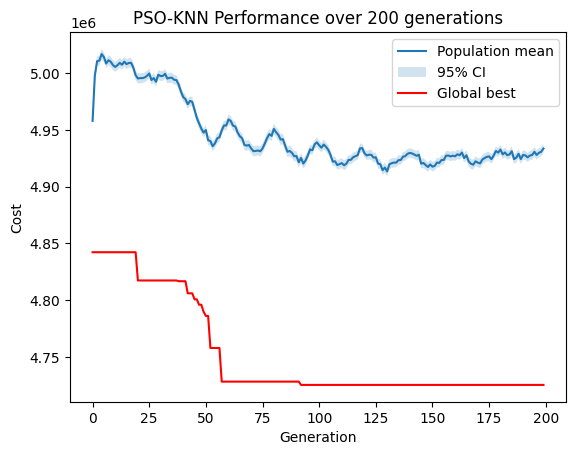

In [77]:
# pop_fitness = np.array(pop_fitness)
mu = np.mean(pop_fitness, axis=1)
sig = np.std(pop_fitness, axis=1)
plt.title('PSO-KNN Performance over {} generations'.format(generations))
plt.ylabel('Cost')
plt.xlabel('Generation')
plt.plot(mu, label='Population mean')
plt.fill_between(range(generations), mu-2*sig/np.sqrt(pop_size), mu+2*sig/np.sqrt(pop_size), alpha=0.2, label='95% CI')
plt.plot(bests, '-r', label='Global best')
plt.legend()
plt.show()

In [ ]:
global_best_station_counter

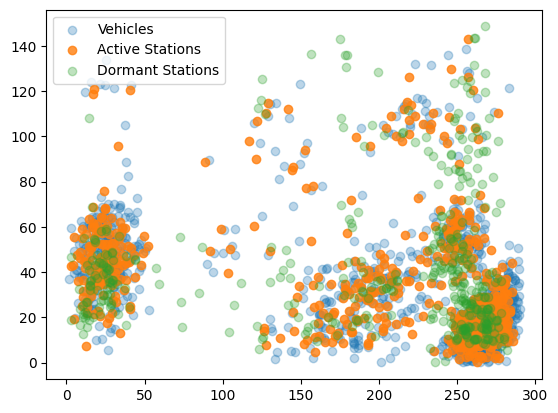

In [78]:
active_stations = np.array([global_best_stations[i] for i in range(global_best_stations.shape[0]) if global_best_station_counter[i] > 0])
dormant_stations = np.array([global_best_stations[i] for i in range(global_best_stations.shape[0]) if global_best_station_counter[i] == 0])

plt.scatter(car_data[:,0], car_data[:,1], label='Vehicles', alpha=0.3)
plt.scatter(active_stations[:,0], active_stations[:,1], alpha=0.8, label='Active Stations')
plt.scatter(dormant_stations[:,0], dormant_stations[:,1], alpha=0.3, label='Dormant Stations')
plt.legend()
plt.show()


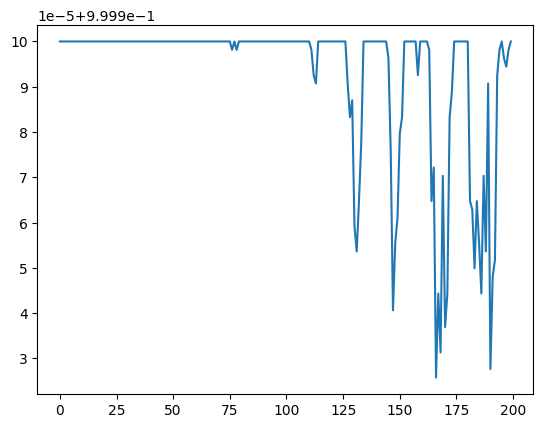

In [ ]:
plt.plot(mean_prop)

In [79]:
active_stations.shape

(599, 2)

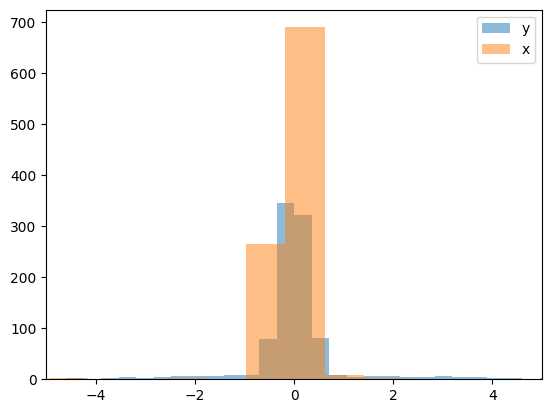

In [82]:
plt.hist(population[0].velocities[:,1], label='y', alpha=0.5, bins=1000)
plt.hist(population[0].velocities[:,0], label='x', alpha=0.5, bins=1000)
plt.xlim((-5,5))
plt.legend()
plt.show()

In [ ]:
plt.hist(population[global_best_index].distance_to_station)

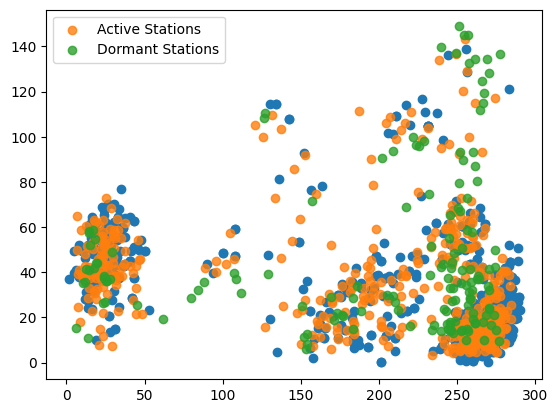

In [ ]:
plt.scatter(car_data_anchor[:,0], car_data_anchor[:,1])
plt.scatter(active_stations[:,0], active_stations[:,1], alpha=0.8, label='Active Stations')
plt.scatter(dormant_stations[:,0], dormant_stations[:,1], alpha=0.8, label='Dormant Stations')
plt.legend()

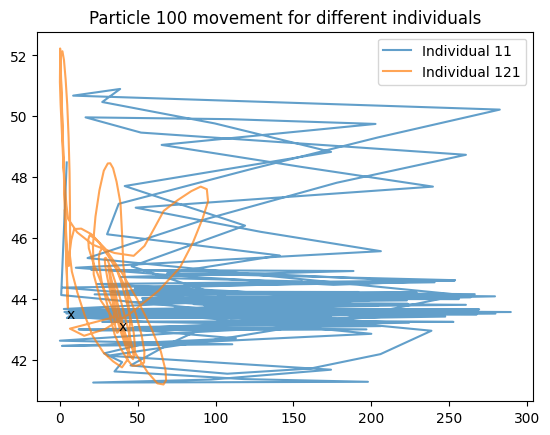

In [80]:
choose_individual = [11,121]
choose_particle = [100,100]
particle = [[i[choose_individual[j]][choose_particle[j]] for i in particle_movement] for j in range(len(choose_particle))]
for k in range(len(choose_individual)):
  plt.plot(np.array(particle[k])[:,0], np.array(particle[k])[:,1], alpha=0.7, label='Individual '+str(choose_individual[k]))
  counter = 1
  for i in particle[k]:
    # plt.scatter(i[0], i[1])
    if counter == generations:
      plt.annotate('x', (i[0], i[1]))
    # else:
      # plt.annotate(counter, (i[0], i[1]), alpha=1-counter/generations)
    counter+=1
plt.legend()
plt.title('Particle {} movement for different individuals'.format(choose_particle[0]))
plt.show()

In [ ]:
station_data = pd.DataFrame(active_stations, columns=['x', 'y'])
station_counts = [global_best_station_counter[i] for i in global_best_station_counter if global_best_station_counter[i] > 0]
station_data['chargers'] = station_counts
station_data.to_excel('/content/drive/MyDrive/MOPTA/station_data_PSO_stochastic_2.xlsx', index=None)


# Comparing two solutions

In [ ]:
s1 = pd.read_excel('/content/drive/MyDrive/MOPTA/station_data_PSO_stochastic.xlsx')
s2 = pd.read_excel('/content/drive/MyDrive/MOPTA/station_data_PSO_stochastic_2.xlsx')
s3 = pd.read_excel('/content/drive/MyDrive/MOPTA/station_data_PSO.xlsx')

In [ ]:
# total chargers
sum(s1['chargers']),sum(s2['chargers'])

(3916, 3932)

In [ ]:
# total stations
s1.shape[0], s2.shape[0]

(457, 451)

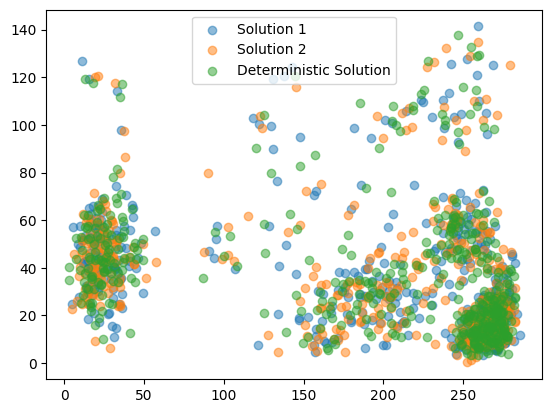

In [ ]:
plt.figure()
plt.scatter(s1['x'], s1['y'], label='Solution 1', alpha=0.5)
plt.scatter(s2['x'], s2['y'], label='Solution 2', alpha=0.5)
plt.scatter(s3['x'], s3['y'], label='Deterministic Solution', alpha=0.5)
# plt.xlim(250,260)
# plt.ylim(10,30)
plt.legend()
plt.show()

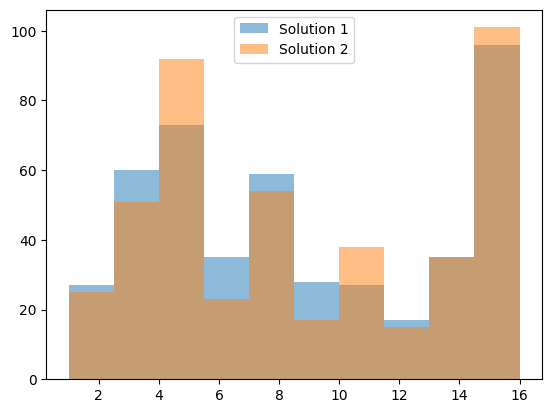

In [ ]:
plt.hist(s1['chargers'], label='Solution 1', alpha=0.5)
plt.hist(s2['chargers'], label='Solution 2', alpha=0.5)
plt.legend()
plt.show()


In [ ]:
tree = BallTree(s1, leaf_size=2)
dist1, ind_closest = tree.query(s2, k=1) # indices of closest stations

tree = BallTree(s2, leaf_size=2)
dist2, ind_closest = tree.query(s1, k=1) # indices of closest stations

tree = BallTree(s3, leaf_size=2)
dist3, ind_closest = tree.query(s1, k=1) # indices of closest stations

tree = BallTree(s3, leaf_size=2)
dist4, ind_closest = tree.query(s2, k=1) # indices of closest stations

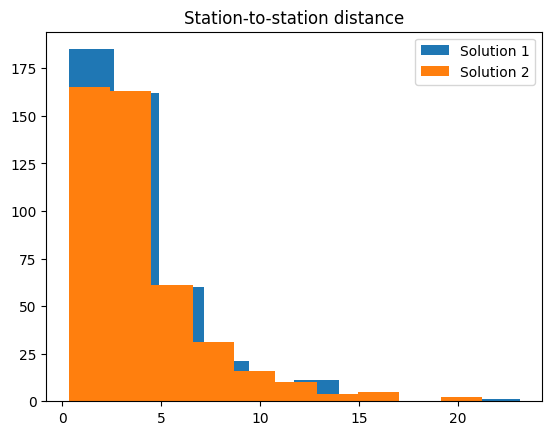

In [ ]:
plt.hist(dist1, label='Solution 1')
plt.hist(dist2, label='Solution 2')
plt.title('Station-to-station distance')
plt.legend()
plt.show()

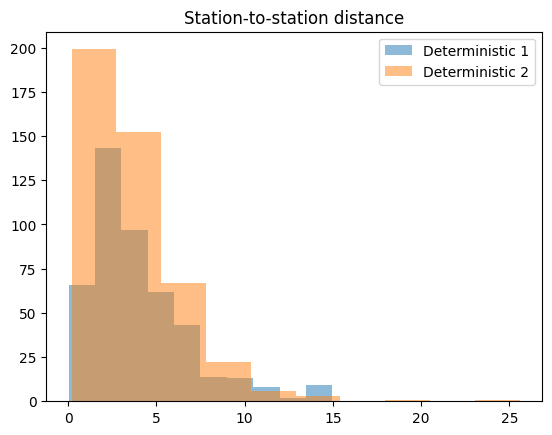

In [ ]:
plt.hist(dist3, label='Deterministic 1', alpha=0.5)
plt.hist(dist4, label='Deterministic 2', alpha=0.5)
plt.title('Station-to-station distance')
plt.legend()
plt.show()

In [15]:
ind_closest[[0]]

array([[  9, 442, 273, 808,  16,  34, 266, 237, 940,   6, 629, 512, 506,
        963, 253,  53, 862,  44, 366, 857, 953,  36, 639, 492, 783, 928,
        977,  10, 376, 167,  54, 640, 202, 628, 884, 914, 967, 924, 827,
        871, 818, 369, 638, 504, 514, 594, 649,  33, 752, 786]])

# Code Graveyard

In [ ]:
population = gen_pop(pop_size)

start = time.time()

K = 100 # number of nearest-stations to find for a vehicle

ranges = get_samples()
S = 16

# get visiting probabilities
c = compute_visiting_probability(ranges)
# number of vehicles per batch
v_b = np.round(c * 10, 0)
# exclude vehicles with a low probability of charging
exclusion = 0.2*10

# vehicle batches which have a strong enough probability of visiting a charger
applicable_vehicles = np.array([v for v in range(v_b.shape[0]) if v_b[v] > exclusion])
applicable_ranges = ranges[applicable_vehicles]

v_b = v_b[applicable_vehicles]

print("There are {} applicable vehicles nodes".format(applicable_vehicles.shape[0]))
vehicle_positions = car_data[applicable_vehicles]
vehicle_dict = {j : vehicle_positions[j] for j in range(vehicle_positions.shape[0])}

# station positions
station_dict = {j : population[0].positions[j] for j in range(n_individual)}
# station position array
station_positions = np.array([station_dict[i] for i in station_dict])

distances = np.zeros((vehicle_positions.shape[0], n_individual))
for s in range(n_individual):
    distances[:,s] = calculate_distance(vehicle_positions, population[0].positions[s]) ########################### POPULATIONS INDIVIDUAL

# find the indices of applicable stations
tree = BallTree(station_positions, leaf_size=2)
# ind = tree.query_radius(vehicle_positions, r=applicable_ranges) # indices of stations that are in range of vehicles
# ind_range = tree.query_radius(vehicle_positions, r=applicable_ranges) # indices of stations that are in range of vehicles
dist, ind_closest = tree.query(vehicle_positions, k=K) # indices of closest stations

# dictionary of how many chargers at each station
station_counter = {i : 0 for i in range(station_positions.shape[0])}
vehicle_assignments = {i : None for i in range(vehicle_positions.shape[0])}
distance_to_station = []
charging_costs = []

shuffle_vehicle_indices = list(range(vehicle_positions.shape[0]))
random.shuffle(shuffle_vehicle_indices)

assigned = 0

# for each vehicle, find a station with availability and add the vehicle batch to that station
for v in shuffle_vehicle_indices:
  for ind in range(ind_closest[v].shape[0]):
    if station_counter[ind_closest[v][ind]] + v_b[v] <= S:
      station_counter[ind_closest[v][ind]] += v_b[v]
      vehicle_assignments[v] = ind_closest[v][ind]
      distance_to_station.append(dist[v][ind])
      charging_costs.append(charging_cost_per_mile * v_b[v] * (250 - applicable_ranges[v] - dist[v][ind]))
      assigned += 1
      break

# calculate the cost
# driving cost
driving_cost = sum(distance_to_station) * driving_cost_per_mile
# charging cost
charging_cost = sum(charging_costs)
# station cost, charger cost
station_cost, charger_cost = 0,0
for s in station_counter:
  station_cost += construction_cost_per_station * (station_counter[s] > 0)
  charger_cost += maintenance_fee_per_charger * station_counter[s]
# penalty cost (% assigned) (1-pct_assigned)*M
pct_assigned = assigned/vehicle_positions.shape[0]
penalty_cost_no_assignment_made = (1-pct_assigned) * no_assignment_penalty
# penalty cost for exceeding range

total_cost = driving_cost + charging_cost + station_cost + charger_cost + penalty_cost_no_assignment_made

print("{:.3f} seconds".format(time.time()-start))
print("{:.3f}% assigned".format(100*pct_assigned))
print("Mean distance to station: {:.2f}".format(np.mean(distance_to_station)))
print("Total cost: {:.2f}".format(total_cost))
plt.title('Histogram of distance to station')
plt.xlabel('Distance')
plt.hist(distance_to_station, alpha=0.5)
plt.show()

In [ ]:
def compute_visiting_probability(ranges:np.array, lam:float=0.012):
    return np.exp(-lam**2 * (ranges - 20)**2 )

# Calculate the pairwise distances between points in the two arrays
def calculate_distance(car_location, station_location):
    return np.linalg.norm(car_location - station_location, axis=1)

def MIP(vehicles, stations, distances, v_b):
  L = 8
  L_max = 16
  A = 1000

  M = 500

  m = pyo.ConcreteModel('vehicle assignment')

  m.VEHICLES = pyo.Set(initialize = vehicles.keys())
  m.STATIONS = pyo.Set(initialize = stations.keys())

  m.x = pyo.Var(m.VEHICLES * m.STATIONS, domain=pyo.Binary)
  m.tau = pyo.Var(m.STATIONS, domain=pyo.NonNegativeReals)
  m.y = pyo.Var(m.STATIONS, domain=pyo.Binary)

  @m.Objective(sense=pyo.minimize)
  def minimize_allocation(m):
      return sum(m.x[vehicle, station] * (distances[vehicle, station]) * driving_cost_per_mile * v_b[vehicle] for vehicle in m.VEHICLES for station in m.STATIONS) + M * sum(m.tau[s] for s in m.STATIONS) + sum(m.x[v, s] * (250-(distances[v, s])) * charging_cost_per_mile for v in m.VEHICLES for s in m.STATIONS)

  @m.Constraint(m.STATIONS)
  def max_chargers(m, station):
      # return sum(m.x[v, station] * c[v] for v in m.VEHICLES) <= L
      return sum(m.x[v, station] for v in m.VEHICLES) <= L_max

  @m.Constraint(m.VEHICLES)
  def single_allocation(m, vehicle):
      return sum(m.x[vehicle, s] for s in m.STATIONS) == 1

  @m.Constraint(m.VEHICLES, m.STATIONS)
  def max_range(m, vehicle, station):
      return m.x[vehicle, station] * distances[vehicle, station] <= 100

  @m.Constraint(m.STATIONS)
  def tau1(m, station):
      return L - sum(m.x[v, station] * v_b[v] for v in m.VEHICLES) <= A * m.y[station]

  @m.Constraint(m.STATIONS)
  def tau2(m, station):
      return sum(m.x[v, station] * v_b[v] for v in m.VEHICLES) - L <= A * (1 - m.y[station])

  @m.Constraint(m.STATIONS)
  def tau3(m, station):
      return m.tau[station] <= sum(m.x[v, station] * v_b[v] for v in m.VEHICLES)

  @m.Constraint(m.STATIONS)
  def tau4(m, station):
      return m.tau[station] <= L

  @m.Constraint(m.STATIONS)
  def tau5(m, station):
      return m.tau[station] >= sum(m.x[v, station] * v_b[v] for v in m.VEHICLES) - A * (1 - m.y[station])

  @m.Constraint(m.STATIONS)
  def tau6(m, station):
      return m.tau[station] >= L - A * m.y[station]

  result = solver.solve(m)

  Z = np.zeros((max(vehicles)+1, max(stations)+1))
  for i in m.VEHICLES:
    for j in m.STATIONS:
      Z[i, j] = m.x[i, j]()

  return m.minimize_allocation(), Z

In [ ]:
def solve_MIP(population, car_data, local_best_scores):
  for i in range(len(population.keys())):
    # sample vehicle ranges
    ranges = get_samples()

    # get visiting probabilities
    c = compute_visiting_probability(ranges)
    # number of vehicles per batch
    v_b = np.round(c * 10, 0)
    # exclude vehicles with a low probability of charging
    exclusion = 0.3*10

    # vehicle batches which have a strong enough probability of visiting a charger
    applicable_vehicles = np.array([v for v in range(v_b.shape[0]) if v_b[v] > exclusion])

    print("There are {} applicable vehicles nodes".format(applicable_vehicles.shape[0]))
    vehicle_positions = car_data[applicable_vehicles]
    vehicle_dict = {j : vehicle_positions[j] for j in range(vehicle_positions.shape[0])}

    # station positions
    station_dict = {j : population[i].positions[j] for j in range(n_individual)}
    
    distances = np.zeros((vehicle_positions.shape[0], n_individual))
    for s in range(n_individual):
        distances[:,s] = calculate_distance(vehicle_positions, population[i].positions[s])

    obj, X = MIP(vehicle_dict, station_dict, distances, v_b)

    # counting how many stations are active and subsequent cost
    active_stations = [j for j in range(X.shape[1]) if np.sum(X[:, j]) > 0]
    active_station_cost = construction_cost_per_station * len(active_stations)

    total_cost = active_station_cost + obj

    population[i].cost = total_cost

    if total_cost < local_best_scores[i]:
      local_best_scores[i] = total_cost
      population[i].best_positions = population[i].positions

    return obj, X
